In [1]:
# ignoring warnings to aesthetics
import warnings
warnings.simplefilter("ignore", UserWarning)



In [2]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms

In [4]:
#checking to see if PyTorch is working fine
a = torch.randn(2,3)
print(a)

tensor([[-1.5586,  0.0938, -1.6357],
        [ 0.7932, -1.1770, -0.9216]])


In [5]:
# google drive path folder containing train, validation and test image folders

data_dir = '/content/drive/MyDrive/Afo'



In [63]:
# defining the transforms to be done on images
# converting images and labels to tensors 
# batch normalising by converting pixel to (0-1)

train_transforms = transforms.Compose([
transforms.Resize(255),transforms.CenterCrop(244),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize(255),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])




In [71]:
# Pass transforms in here, then run the next cell to see how the transforms look

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform = valid_transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


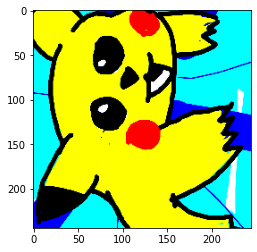

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


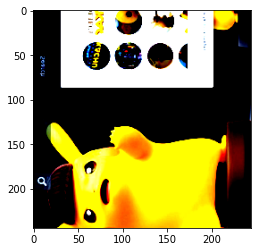

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


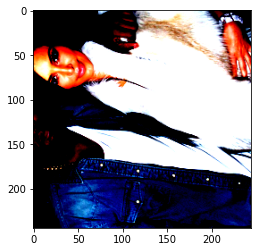

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


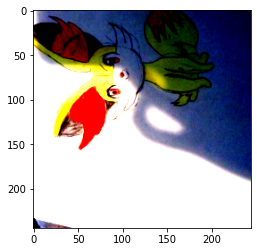

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


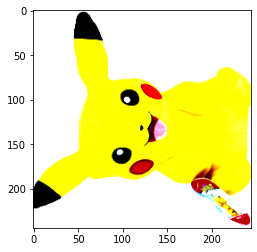

In [67]:
# Pytorch does automatic labelling for various classes (Kanye, Cat, Pikachu)
# checking what labels are being assigned
# we can see the labelling as 0: kanye, 1: Pikachu, 2: cat

dataiter = iter(trainloader)
images, labels = dataiter.next()
for i in range(5):
  plt.imshow(images[i].numpy().squeeze().T, cmap = 'gray_r')
  print(labels[i])
  plt.show()
  

In [10]:
# checking if Cuda is available for faster training

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [11]:
# using densenet 121 model pre-trained on imagenet dataset
# https://pytorch.org/hub/pytorch_vision_densenet/ for more info on densenet121

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)


# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# defining the first layer and the last layer
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 3),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [13]:

# Only train the classifier parameters, feature parameters are frozen

# you can see that the accuracy on validation set is around 97% which is quite satisfying.


optimizer = optim.SGD(model.classifier.parameters(), lr=0.003)
model.to(device)
epochs = 20
training_loss, validation_l = [],[]
y_pred, y_true, acc_val, acc_train = [],[],[],[]

for epoch in range(epochs):
    train_loss, valid_loss = 0,0
    train_correct = 0
    for inputs, labels in trainloader:
    
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        train_loss += loss.item()
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_correct += equals.sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    training_loss.append(train_loss/len(trainloader.dataset))
    valid_correct = 0
    
    for inputs, labels in validloader:
      with torch.no_grad():
                    model.eval()
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)     
                    valid_loss += batch_loss.item()  
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    y_pred.append(top_class)
                    y_true.append(labels.view(*top_class.shape))
                    equals = top_class == labels.view(*top_class.shape)
                    valid_correct += equals.sum().item()

    acc_train.append(train_correct/len(trainloader.dataset))
    acc_val.append(valid_correct/len(validloader.dataset))
    validation_l.append(valid_loss/len(validloader.dataset))               
    print(f"Epoch {epoch+1}/{epochs}.. "
                        f"train loss: {train_loss/len(trainloader.dataset):.3f}.. "
                        f"train_accuracy: {train_correct/len(trainloader.dataset):.3f}.."
                        f"val_loss: {valid_loss/len(validloader.dataset):.3f}.. "
                        f"val_accuracy: {valid_correct/len(validloader.dataset):.3f}")
  
    model.train()


Epoch 1/20.. train loss: 0.012.. train_accuracy: 0.912..val_loss: 0.011.. val_accuracy: 0.957
Epoch 2/20.. train loss: 0.009.. train_accuracy: 0.955..val_loss: 0.008.. val_accuracy: 0.967
Epoch 3/20.. train loss: 0.007.. train_accuracy: 0.958..val_loss: 0.006.. val_accuracy: 0.965
Epoch 4/20.. train loss: 0.005.. train_accuracy: 0.966..val_loss: 0.005.. val_accuracy: 0.970
Epoch 5/20.. train loss: 0.004.. train_accuracy: 0.971..val_loss: 0.004.. val_accuracy: 0.970
Epoch 6/20.. train loss: 0.003.. train_accuracy: 0.967..val_loss: 0.003.. val_accuracy: 0.969
Epoch 7/20.. train loss: 0.003.. train_accuracy: 0.974..val_loss: 0.003.. val_accuracy: 0.969
Epoch 8/20.. train loss: 0.003.. train_accuracy: 0.971..val_loss: 0.003.. val_accuracy: 0.974
Epoch 9/20.. train loss: 0.002.. train_accuracy: 0.973..val_loss: 0.002.. val_accuracy: 0.972
Epoch 10/20.. train loss: 0.002.. train_accuracy: 0.973..val_loss: 0.002.. val_accuracy: 0.970
Epoch 11/20.. train loss: 0.002.. train_accuracy: 0.971..va

In [14]:
# validation accuracy

print("validation_accuracy:{}%".format(np.mean(acc_val)*100))

validation_accuracy:96.97693574958812%


[]

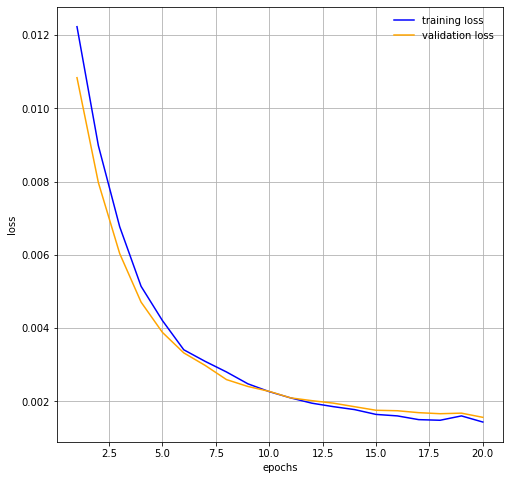

In [32]:
# plotting the graph validation loss and training loss v/s the no. of epochs

import matplotlib.pyplot as plt
x = [x for x in range(1,21)]
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
ax = fig.add_subplot()
ax.plot(x,training_loss, color = 'blue', label = 'training loss')
ax.plot(x,validation_l, color = 'orange', label = 'validation loss')
ax.legend(frameon = False)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.grid()
plt.plot()


[]

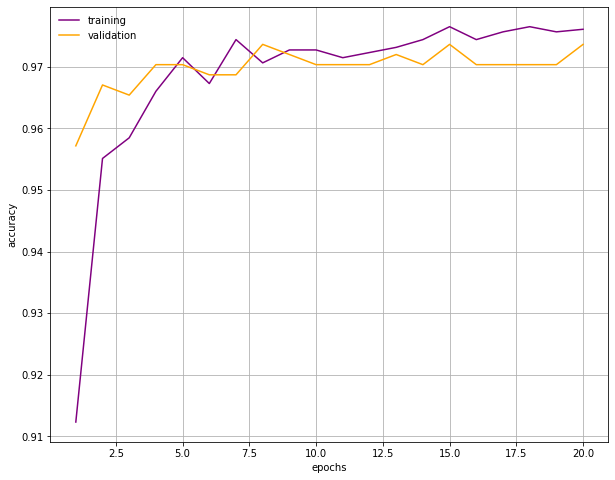

In [33]:
# plotting the graph accuracy v/s epochs

import matplotlib.pyplot as plt
x = [x for x in range(1,21)]
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(8)

ax = fig.add_subplot()
ax.plot(x,acc_train, color = 'purple', label = 'training')
ax.plot(x,acc_val, color = 'orange', label = 'validation')
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.grid()
ax.legend(frameon = False)
ax.plot()


In [36]:
# plotting the confusion matrix on validation set

y_predd, y_truee = [],[]
for i in range(10):
  if i < 9:
    for j in range(64):
      y_predd.append(y_pred[i][j].cpu().item())
      y_truee.append(y_true[i][j].cpu().item())
  else:
      for j in range(31):
        y_predd.append((y_pred[i][j].cpu().item()))
        y_truee.append(y_true[i][j].cpu().item())


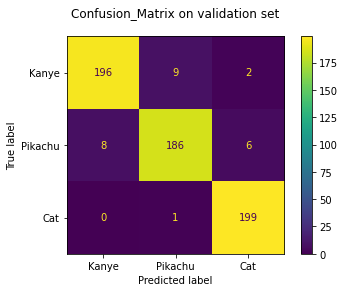

In [37]:
# except few images of Pikachu being confused with Kanye, rest is fine

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_truee, y_predd)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Kanye', 'Pikachu', 'Cat'])
cmd_obj.plot()
plt.title("Confusion_Matrix on validation set", pad = 20)
plt.show()


In [78]:
#running the model on test-set

y_pred, y_true = [],[]
l = 0
test_correct = 0
for inputs, labels in testloader:
      with torch.no_grad():
                    model.eval()
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)     
                    
                    # Calculate accuracy

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    y_pred.append(top_class)
                    y_true.append(labels.view(*top_class.shape))
                    equals = top_class == labels.view(*top_class.shape)
                    test_correct += equals.sum().item()

print("Accuracy on test set: {}%".format(round(test_correct*100/len(testloader.dataset),3)))

Accuracy on test set: 97.297%


In [44]:
y_predd, y_truee = [],[]
for i in range(5):
  if i < 4:
    for j in range(64):
      y_predd.append(y_pred[i][j].cpu().item())
      y_truee.append(y_true[i][j].cpu().item())
  else:
      for j in range(40):
        y_predd.append((y_pred[i][j].cpu().item()))
        y_truee.append(y_true[i][j].cpu().item())


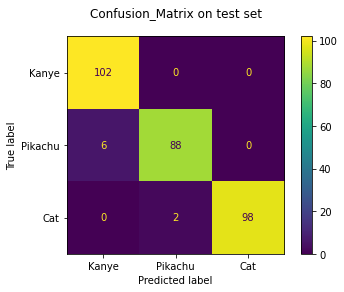

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_truee, y_predd)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Kanye', 'Pikachu', 'Cat'])
cmd_obj.plot()
plt.title("Confusion_Matrix on test set", pad = 20)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I think this is Kanye with 73.2294% probability


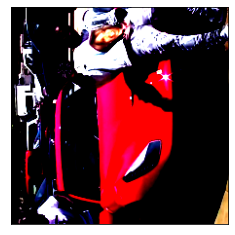

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I think this is cat with 99.0356% probability


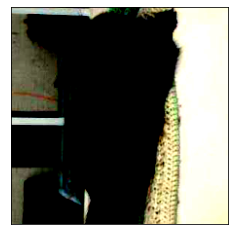

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I think this is Kanye with 63.6546% probability


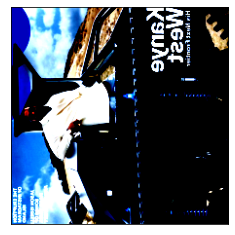

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I think this is cat with 99.6814% probability


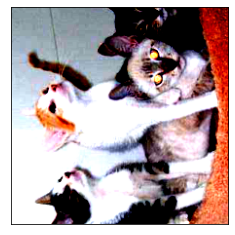

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I think this is Pikachu with 95.7008% probability


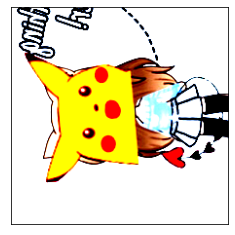

In [79]:
# making predictions on test-set

d = {0:'Kanye', 1:'Pikachu', 2: 'cat'}

for i in range(5):
    #data = next(iter(testloader))
    print("I think this is {} with {}% probability".format(d[top_class[i].item()],round(top_p[i].item()*100,4)))
    plt.imshow((inputs[i].cpu().numpy().squeeze().T))
    plt.xticks([])
    plt.yticks([])
    plt.show()


